In [6]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [99]:
# This cell handles data collection, only run this if you want fresh data
# There is an issue where sometimes the genres of some games gets fetched in different languages,
# This seems to be an issue with Steam's API since we get different languages each time it happens.
# The data file we have provided with the project has all genres in english

appids = [730, 570, 578080, 1172470, 3164500, 2694490, 2923300, 2139460, 322170, 2246340, 252490, 2767030, 1203220, 2507950, 271590, 1086940, 413150,
          236390, 1903340, 3241660, 2252570, 3240220, 1938090, 230410, 489830, 359550, 1174180, 286690, 2669320, 381210, 394360, 440, 322330, 1245620,
          221100, 1085660, 3188910, 438100, 289070, 105600, 227300, 1782210, 1222670, 2878980, 3117820, 294100, 1623730, 346110, 1973530, 1364780]

gameGenres = {
    730: "FPS",
    570: "MOBA",
    578080: "Battle royale",
    1172470: "Battle royale",
    3164500: "Simulation",
    2694490: "RPG",
    2923300: "Clicker",
    2139460: "Survival",
    322170: "Platform",
    2246340: "RPG",
    252490: "Survival",
    2767030: "FPS",
    1203220: "Battle royale",
    2507950: "FPS",
    271590: "RPG",
    1086940: "RPG",
    413150: "Simulation",
    236390: "Simulation",
    1903340: "RPG",
    3241660: "Horror",
    2252570: "Sports",
    3240220: "RPG",
    1938090: "FPS",
    230410: "RPG",
    489830: "RPG",
    359550: "FPS",
    1174180: "RPG",
    286690: "FPS",
    2669320: "Sports",
    381210: "Horror",
    394360: "Strategy",
    440: "FPS",
    322330: "Survival",
    1245620: "RPG",
    221100: "Survival",
    1085660: "FPS",
    3188910: "Clicker",
    438100: "Virtual Reality",
    289070: "Strategy",
    105600: "Survival",
    227300: "Simulation",
    1782210: "Battle royale",
    1222670: "Simulation",
    2878980: "Sports",
    3117820: "Strategy",
    294100: "Survival",
    1623730: "Survival",
    346110: "Survival",
    1973530: "Strategy",
    1364780: "Fighting",
}

now = datetime.now(timezone.utc)
thirtyDaysAgo = now - timedelta(days=30)
thirtyDaysAgoTs = int(thirtyDaysAgo.timestamp() * 1000)

def get_game_metadata(appid):
    try:
        res = requests.get(f"https://store.steampowered.com/api/appdetails?appids={appid}")
        res.raise_for_status()
        data = res.json()
        gameData = data[str(appid)]
        if gameData["success"]:
            name = gameData["data"].get("name", f"Unknown_{appid}")
            return name
    except Exception as e:
        print(f"Failed to get metadata for {appid}: {e}")
    return f"Unknown_{appid}", "Unknown"

allData = []

for appid in appids:
    name = get_game_metadata(appid)

    genre = gameGenres.get(appid, "Unknown")

    try:
        url = f"https://steamcharts.com/app/{appid}/chart-data.json"
        res = requests.get(url)
        res.raise_for_status()
        data = res.json()

        for timestamp, playerCount in data:
            if timestamp >= thirtyDaysAgoTs:
                date = pd.to_datetime(timestamp, unit="ms")
                allData.append({
                    "Game": name,
                    "Genre": genre,
                    "Date": date,
                    "Player Count": playerCount
                })
    except Exception as e:
        print(f"Failed to fetch chart data for {name} (AppID {appid}): {e}")

df = pd.DataFrame(allData)
df.sort_values(by=["Game", "Date"], inplace=True)
df.to_csv("steamcharts_30_days.csv", index=False)

In [8]:
playerData = pd.read_csv('steamcharts_30_days.csv')

In [10]:
# Normalize AvgPlayers per game and store in a new column
playerData["NormalizedPlayerCount"] = playerData.groupby("Game")["Player Count"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 0
)

In [12]:
playerData = playerData[playerData["Player Count"] != 0]
playerData["Date"] = pd.to_datetime(playerData["Date"])
playerData["DayOfWeek"] = playerData["Date"].dt.day_name()

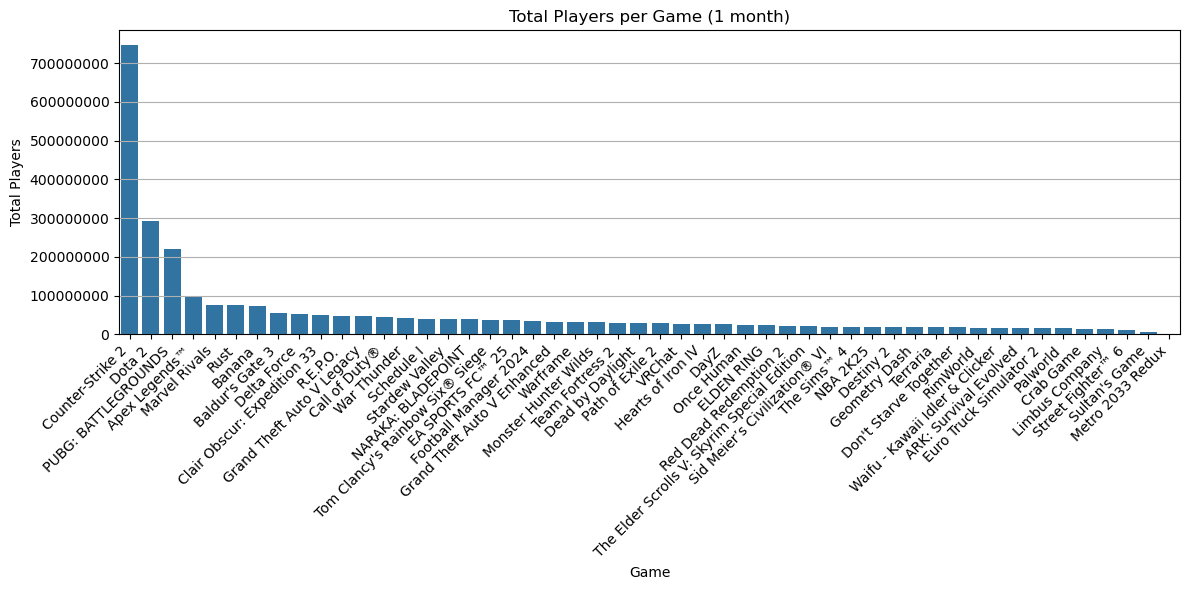

In [14]:
gameTotal = playerData.groupby("Game")["Player Count"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=gameTotal.index, y=gameTotal.values)

plt.title("Total Players per Game (1 month)")
plt.xlabel("Game")
plt.ylabel("Total Players")

# Format y-axis to plain numbers (no scientific notation)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

This barplot shows the total number of players per game for 1 month calculated by adding the player count for each game in the dataset every hour.

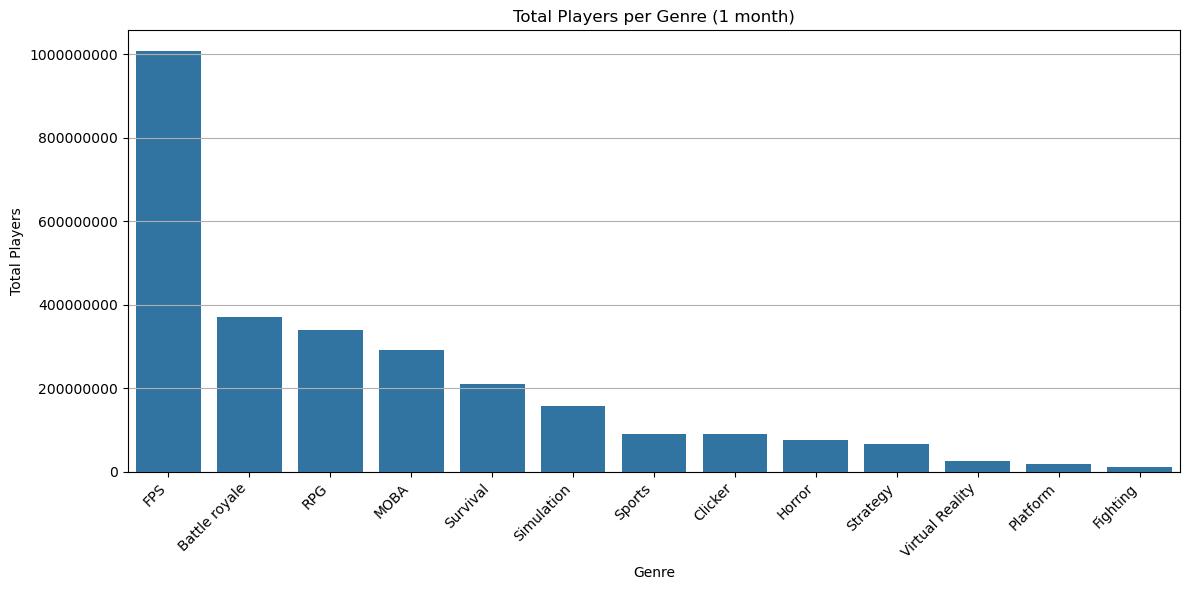

In [16]:
genreTotal = playerData.groupby("Genre")["Player Count"].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=genreTotal.index, y=genreTotal.values)

plt.title("Total Players per Genre (1 month)")
plt.xlabel("Genre")
plt.ylabel("Total Players")

# Format y-axis to plain numbers (no scientific notation)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

This barplot shows the total number of players per genre for 1 month calculated by adding the player count for each game in the dataset every hour.

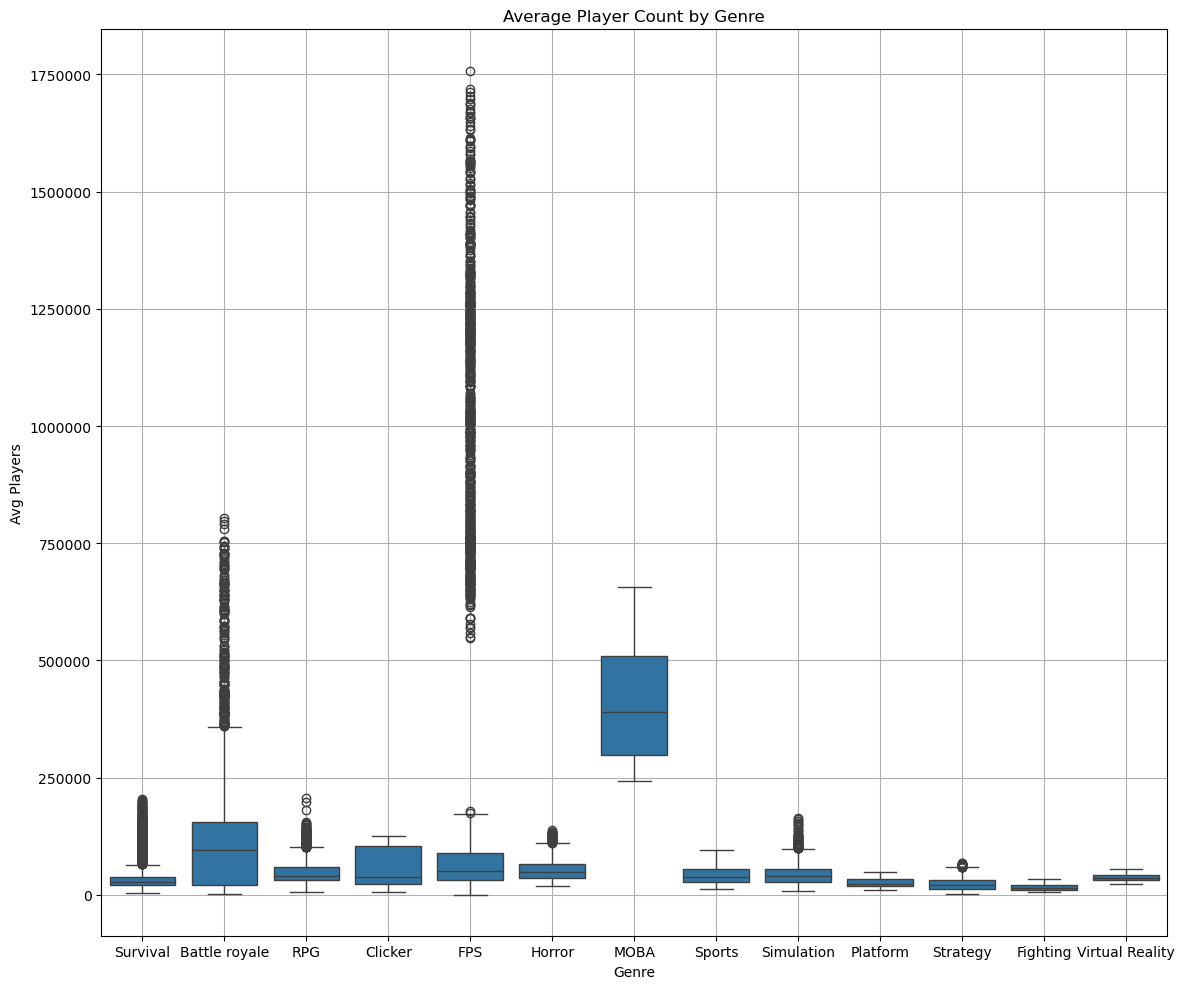

In [18]:
plt.figure(figsize=(12, 10))
sns.boxplot(data=playerData, x="Genre", y="Player Count")

plt.title("Average Player Count by Genre")
plt.xlabel("Genre")
plt.ylabel("Avg Players")

# Force plain formatting for y-axis
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
plt.ticklabel_format(style='plain', axis='y')

plt.grid(True)
plt.tight_layout()
plt.show()

This boxplot shows the average playercount of each genre for 1 month.

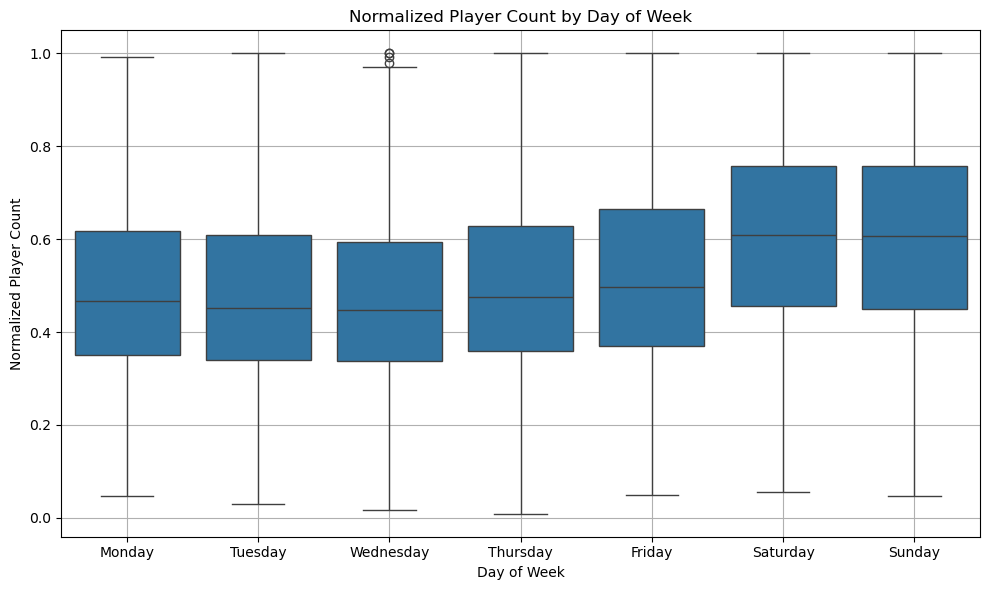

In [20]:
dayOrder = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(10, 6))
sns.boxplot(data=playerData, x="DayOfWeek", y="NormalizedPlayerCount", order=dayOrder)

plt.title("Normalized Player Count by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Normalized Player Count")
plt.grid(True)
plt.tight_layout()
plt.show()

This boxplot shows the average normalized player count in each day of the week.

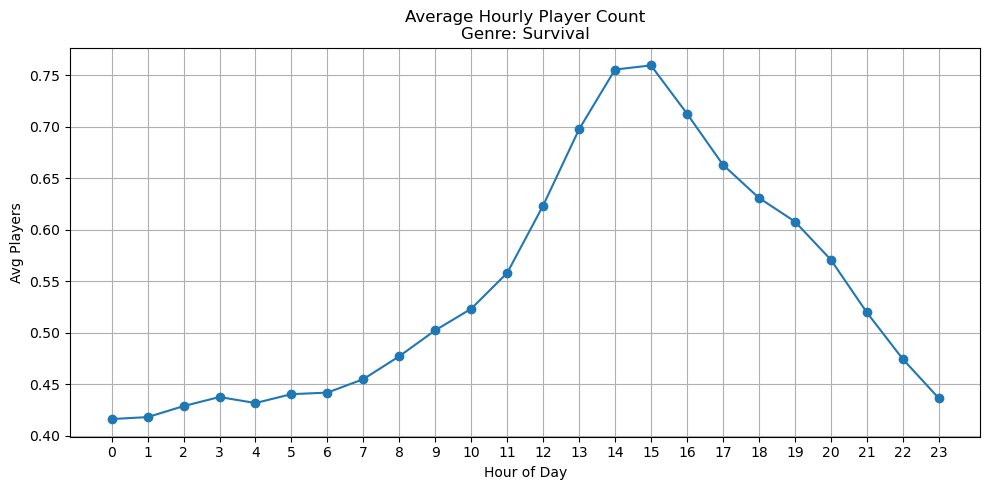

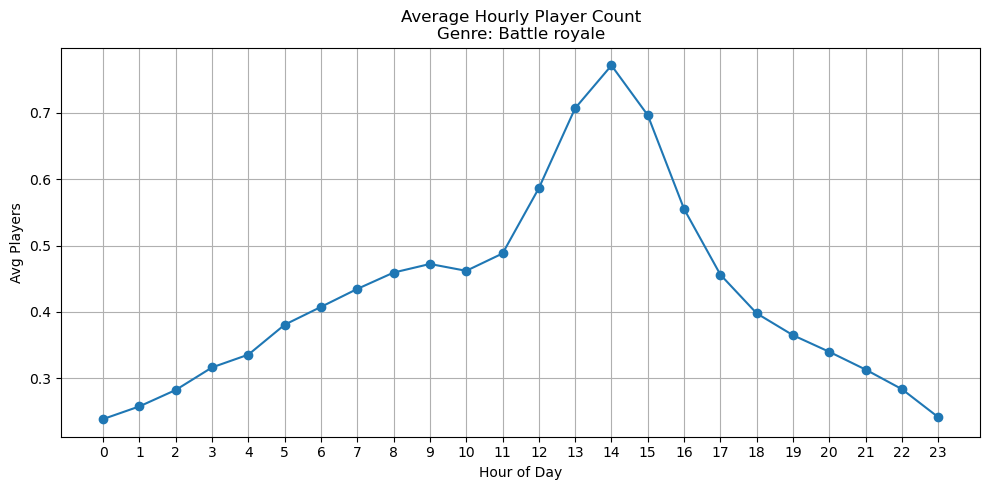

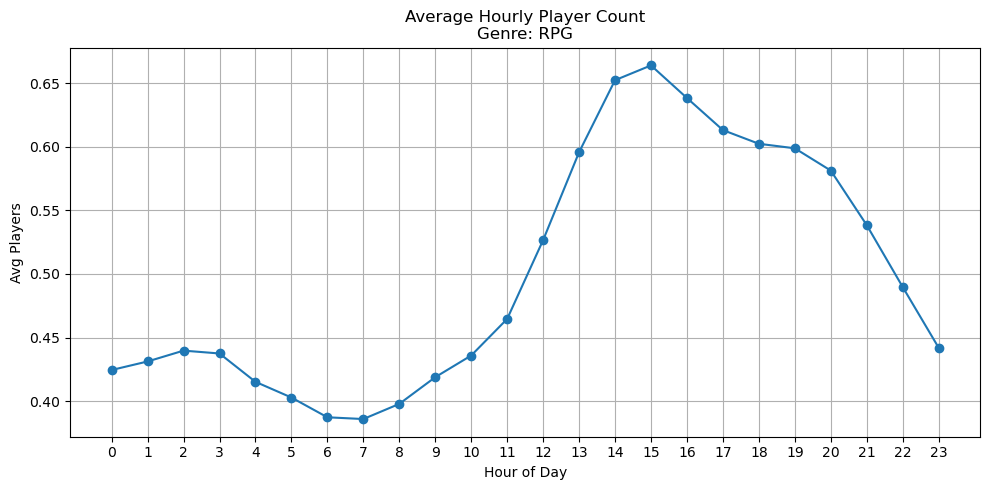

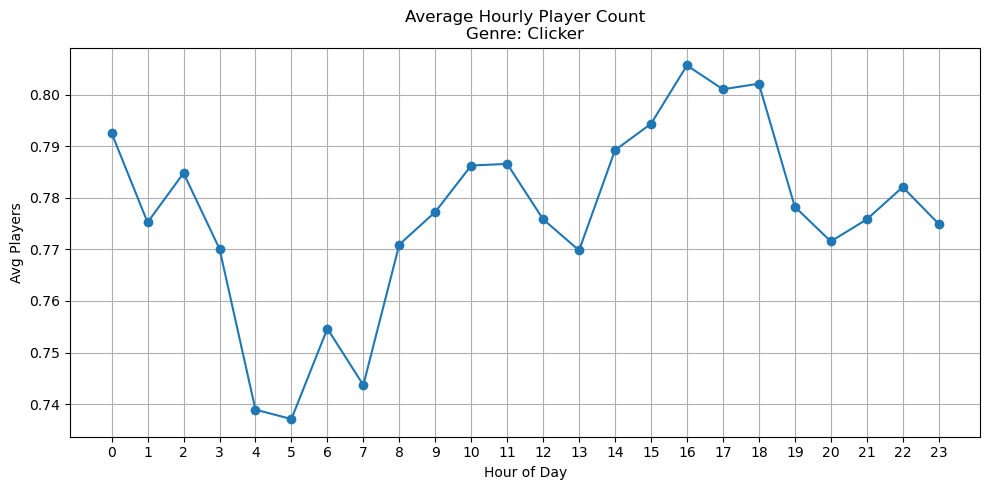

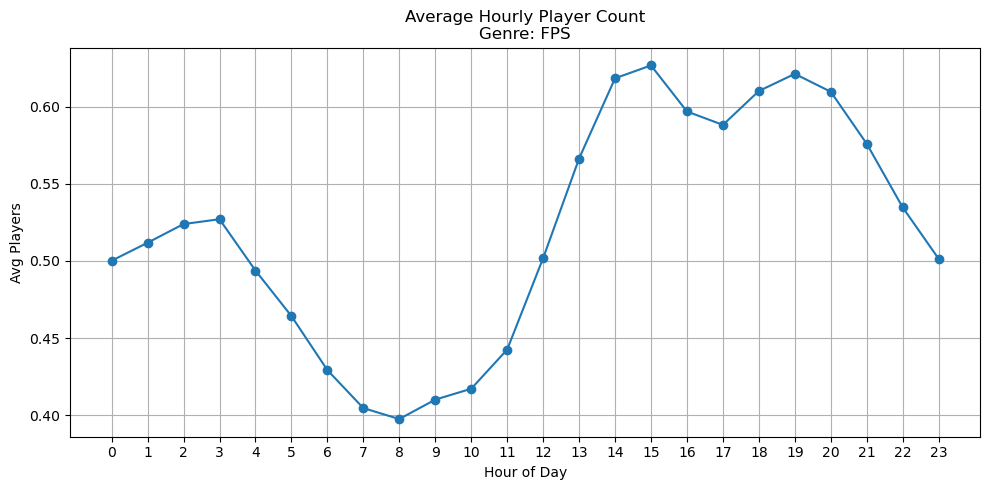

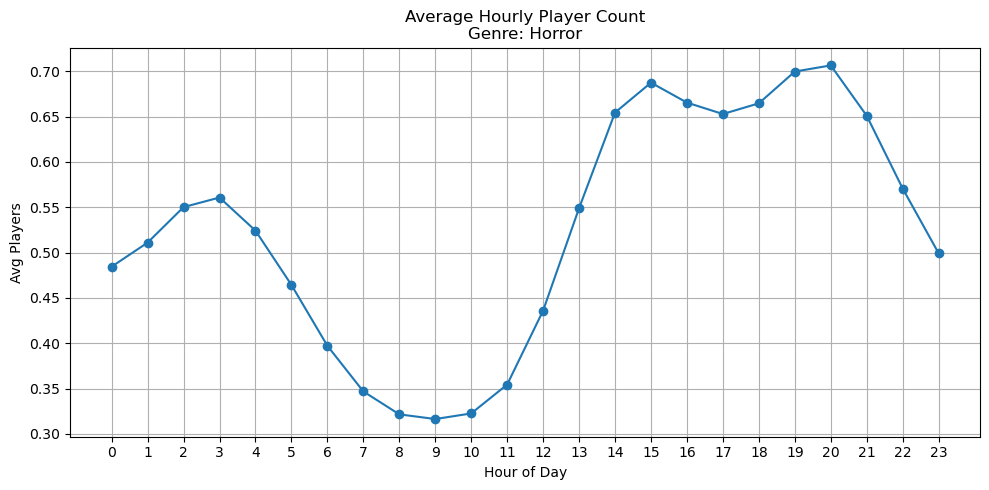

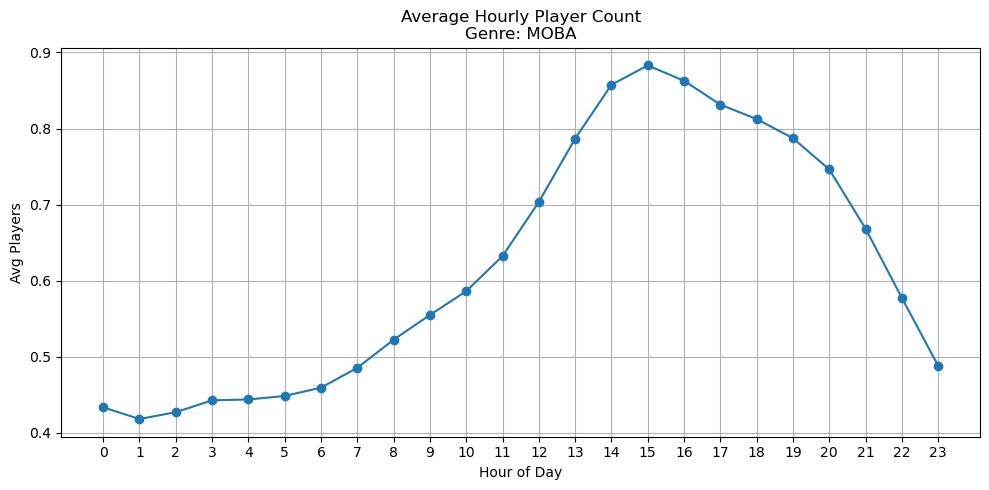

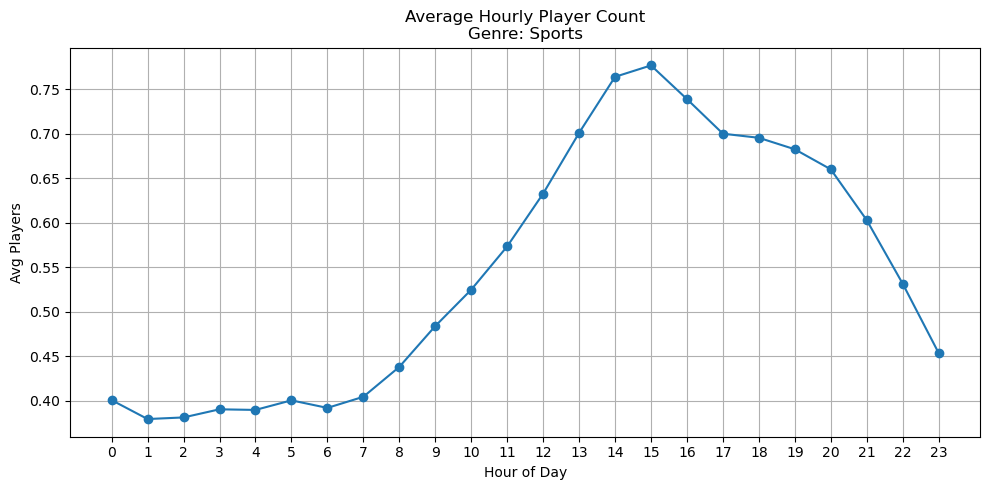

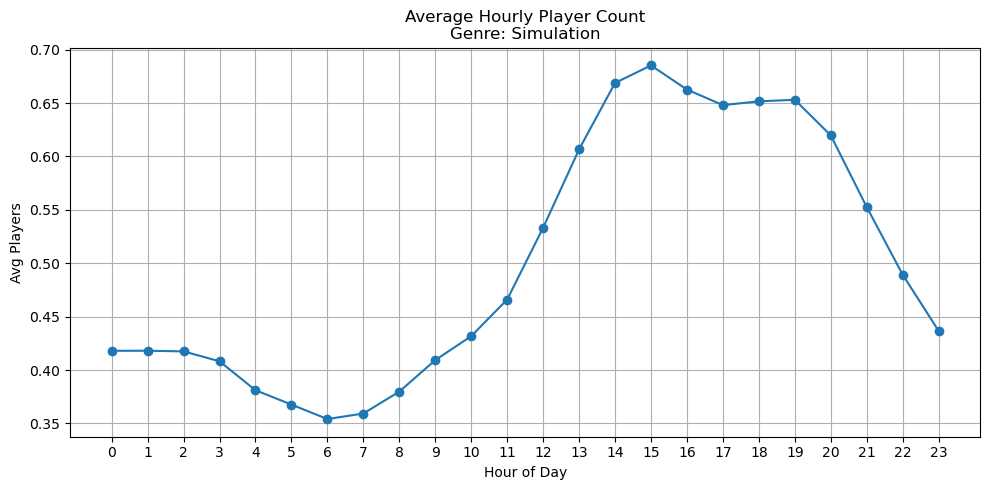

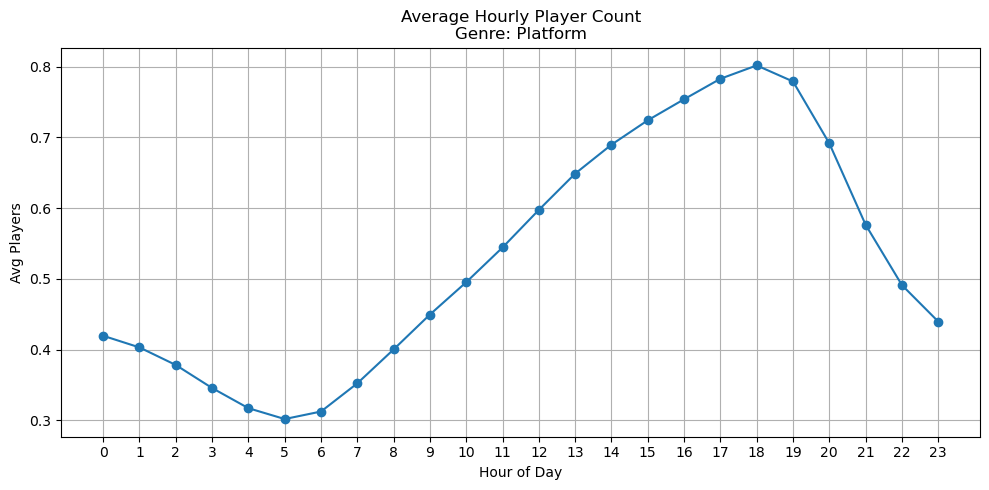

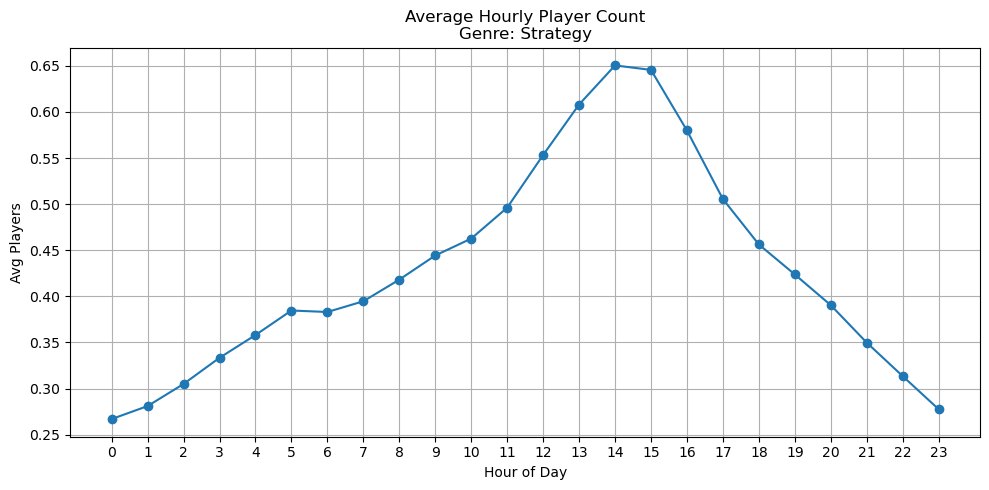

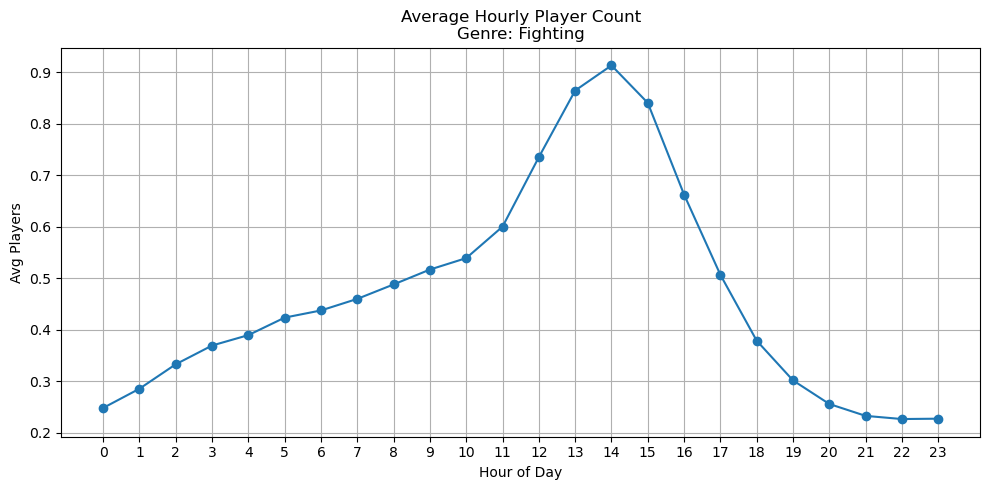

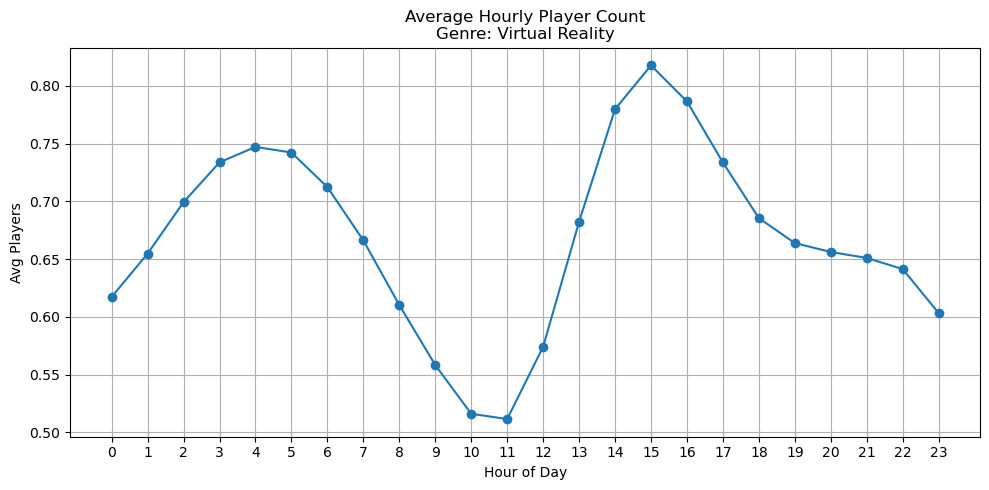

In [22]:
playerData["Hour"] = playerData["Date"].dt.hour

genres = playerData["Genre"].unique()

for genre in genres:
    genre_data = playerData[playerData["Genre"] == genre]
    hourly_avg = genre_data.groupby("Hour")["NormalizedPlayerCount"].mean()

    plt.figure(figsize=(10, 5))
    plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
    plt.xticks(range(0, 24))
    plt.title(f"Average Hourly Player Count\nGenre: {genre}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Avg Players")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C:\Users\kontr\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


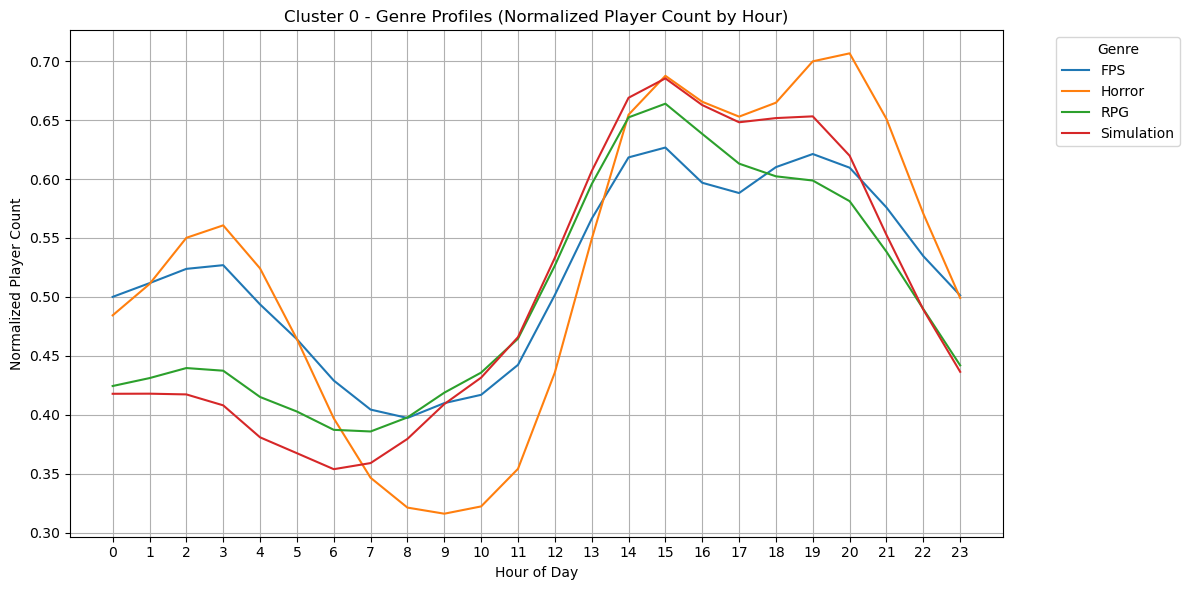

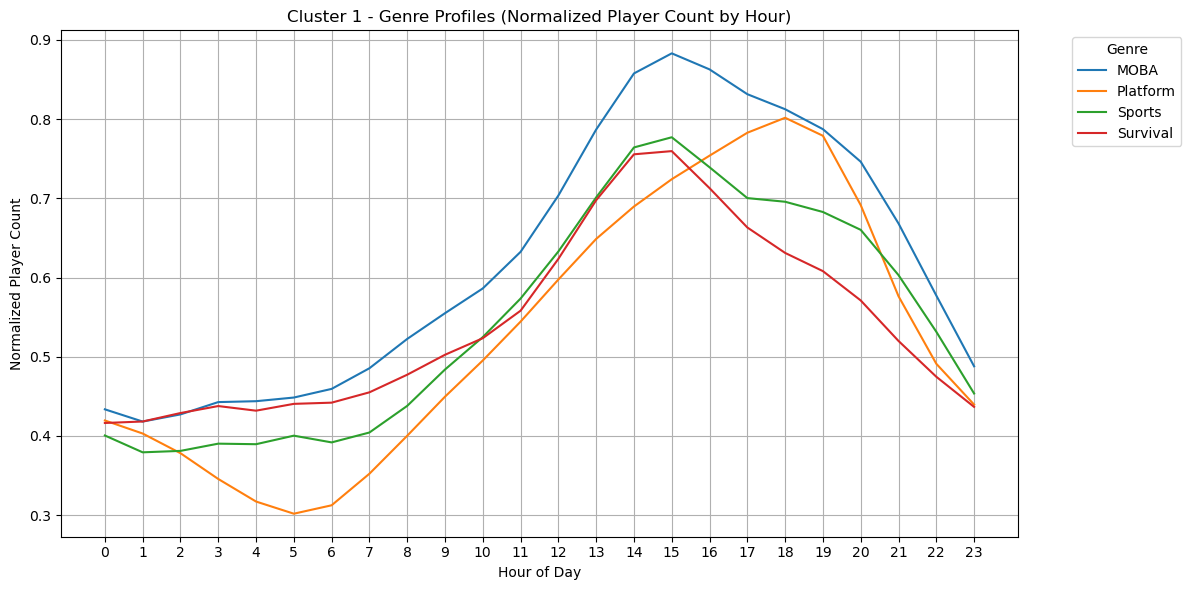

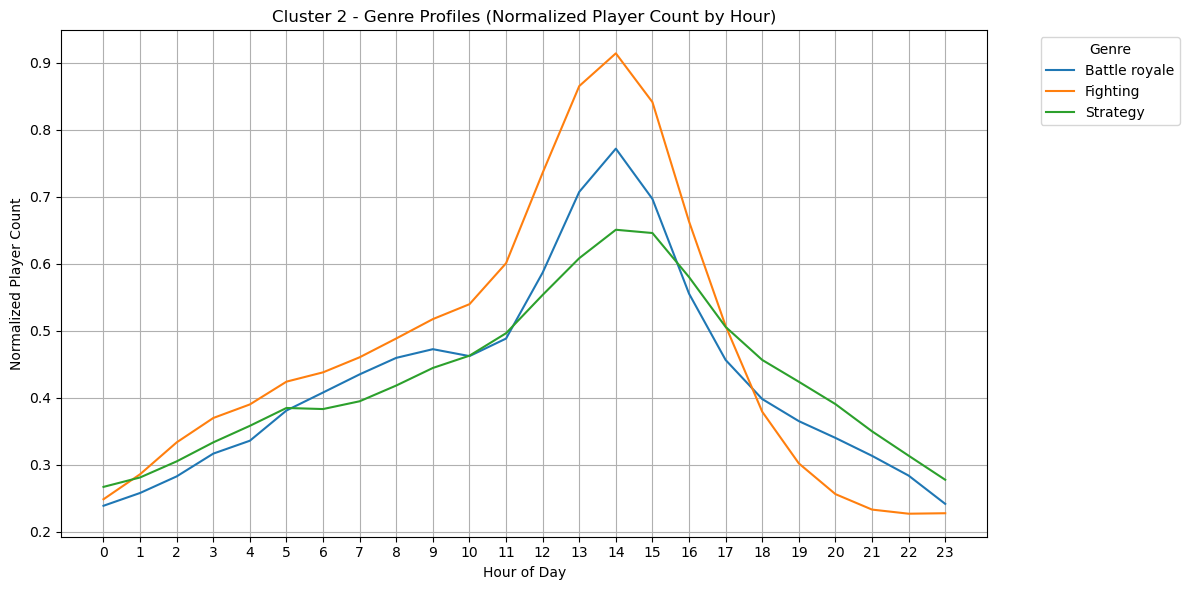

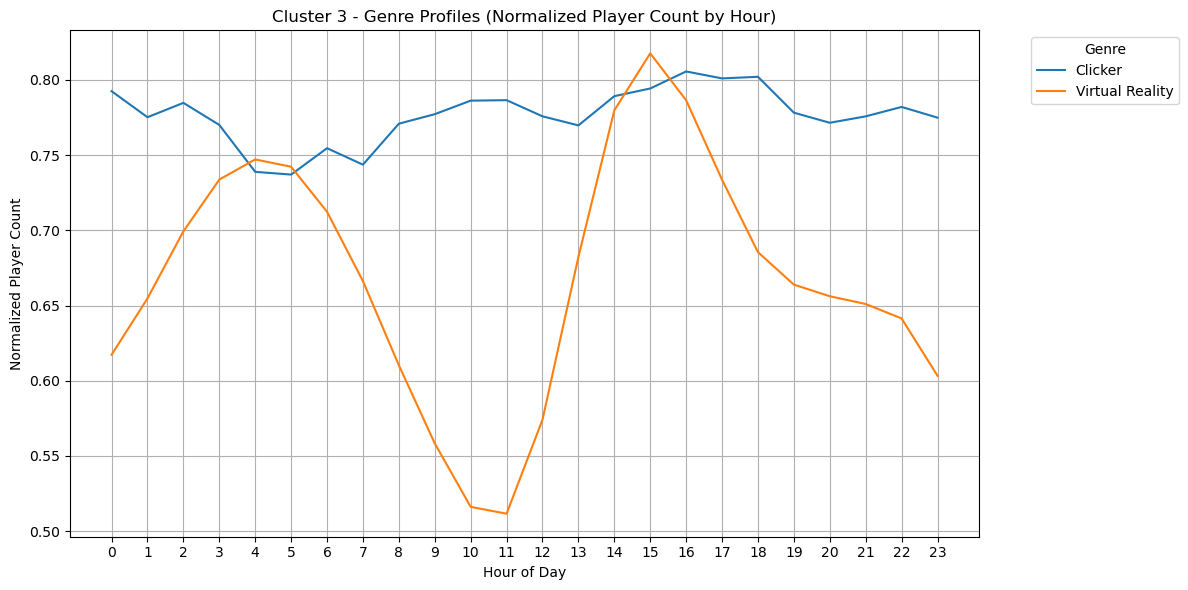

In [43]:
# Compute average normalized player count per hour per genre
genre_hourly = playerData.groupby(["Genre", "Hour"])["NormalizedPlayerCount"].mean().reset_index()

# Pivot to create a matrix: Genre x Hour (each row = 24 hourly features)
genre_matrix = genre_hourly.pivot(index="Genre", columns="Hour", values="NormalizedPlayerCount")

# Fill any missing values (if some genres lack certain hours)
genre_matrix.fillna(0, inplace=True)

# Normalize features (optional but helpful for KMeans)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(genre_matrix)

# Perform KMeans clustering (try 3–5 clusters to start)
kmeans = KMeans(n_clusters=4, random_state=42)
genre_matrix["Cluster"] = kmeans.fit_predict(scaled_data)

# Plot clusters as line plots
for cluster_id in sorted(genre_matrix["Cluster"].unique()):
    plt.figure(figsize=(12, 6))
    cluster_genres = genre_matrix[genre_matrix["Cluster"] == cluster_id].index
    cluster_profiles = genre_matrix.loc[cluster_genres].drop(columns="Cluster")

    for genre in cluster_genres:
        plt.plot(cluster_profiles.columns, cluster_profiles.loc[genre], label=genre)
    
    plt.title(f"Cluster {cluster_id} - Genre Profiles (Normalized Player Count by Hour)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Normalized Player Count")
    plt.xticks(range(0, 24))
    plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In the 2 groups of graphs above we can first see the normalized player count for each genre plotted throughout the hours of the day. Then in the second group of graphs we can see genres with similar player count curves grouped together by k-means clustering. 

This shows the following clusters: 

The genres FPS, Horror, RPG and Simulation have an average amount of players 00-04, a low amount 5-11 and a high amount 14-21. Horror has the most variation out of these 4 genres.

The genres MOBA, Platform, Sports and Survival have a low amount of players 00-09, we start to see a gradual increase at 06 with a peak player count at 15 and starting to decrease again at 19 to an average player count at 22.

The genres Battle royale, Fighting and Strategy have a low amount of players 20-03, 04-10 we see an average player count. Then at 10 we see a rapid spike in player count to a peak at 14, then it rapidly decreases again and bottoms out at a low player count 20.

The genres Clicker and Virtual Reality differs alot from the others and as such this cluster is the remaining outliers. Virtual Reality has two spikes in player count, one at 04 and one at 15. The player count never drops below 0.5 in the normalized scale with the lowest point being at 10-11. Clicker has a consistent high player count during the entire day, this is most likely due to the nature of clicker games being left open continuosly and running automatically in the background.

In [24]:
result = stats.anderson(playerData["NormalizedPlayerCount"])
print(f"Anderson-Darling Test statistic: {result.statistic}")
print("Critical values and significance levels:")
for cv, sl in zip(result.critical_values, result.significance_level):
    print(f"  {sl}%: {cv}")

Anderson-Darling Test statistic: 51.983449493549415
Critical values and significance levels:
  15.0%: 0.576
  10.0%: 0.656
  5.0%: 0.787
  2.5%: 0.918
  1.0%: 1.092


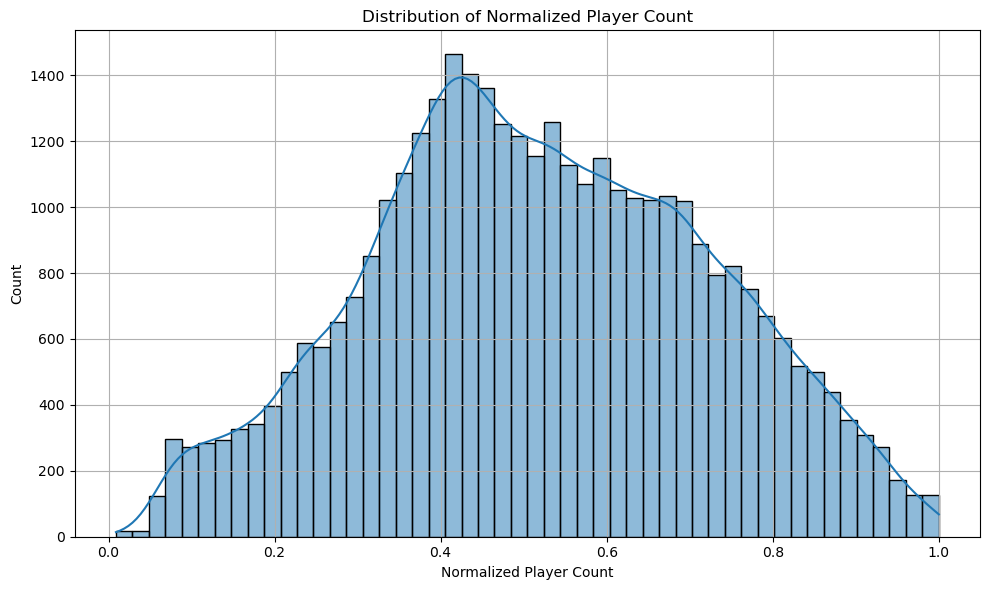

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(playerData["NormalizedPlayerCount"], kde=True, bins=50)
plt.title("Distribution of Normalized Player Count")
plt.xlabel("Normalized Player Count")
plt.grid(True)
plt.tight_layout()
plt.show()

From the above Anderson-Darling test showing a much higher statistic value than any of the significance levels and the visual representation not looking like the normal distribution we can conclude that the dataset doesn't follow a normal distribution, we will take this into consideration when we do further analysis.